# **Style transfer using GAN**
This notebook will be used to prepare the capstone project '[Style transfer using GAN](https://junyanz.github.io/CycleGAN/)'

## **Problem Statement**
Misdiagnosis in the medical field is a very serious issue but it’s also uncomfortably common to occur. Imaging procedures in the medical field requires an expert radiologist’s opinion since interpreting them is not a simple binary process ( Normal or Abnormal). Even so, one radiologist may see something that another does not. This can lead to conflicting reports and make it difficult to effectively recommend treatment options to the patient.

One of the complicated tasks in medical imaging is to diagnose MRI([Magnetic Resonance Imaging](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging)). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.

 

 

But to have access to different imaging is difficult and expensive. With the help of deep learning, we can use style transfer to generate artificial MRI images of different contrast levels from existing MRI scans. This will help to provide a better diagnosis with the help of an additional image.

 

In this capstone, you will use [CycleGAN](https://machinelearningmastery.com/what-is-cyclegan/) [[tf ref.](https://www.tensorflow.org/tutorials/generative/cyclegan)] to translate the style of one MRI image to another, which will help in a better understanding of the scanned image. Using GANs you will create T2 weighted images from T1 weighted MRI image and vice-versa.

 

Problem statement: To build a Generative adversarial model(modified U-Net) which can generate artificial MRI images of different contrast levels from existing MRI scans.


MRI T1_T2 Dataset
Download
NOTE: The T1 and T2 MRI Images included in the dataset are not related in any way since we have an unpaired dataset here.

 

**Project pipeline**

The project pipeline can be briefly summarized in the following three steps:

1. Data Understanding: Here, you need to load the data and create the dataset for it.
2. Image Processing: In this step, you will have to process the images using different steps.
3. Model-Building and Training: This is the final step at which you have to create your Generators and Discriminators using a modified U-Net architecture(similar to CycleGAN). You also have to define the loss function and training step for model training.

# **1. Importing Libraries**

In [1]:
#Import all the required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import pathlib
import imageio
import glob
import PIL

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **2. Data Preparation**
- Loading the data and storing it in tf.dataset
- Perfroming Train-Test split

In [3]:
data_dir_t1 = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Upgrad_MRI_T1_T2_CyclicGAN/dataset/Tr1")
data_dir_t2 = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Upgrad_MRI_T1_T2_CyclicGAN/dataset/Tr2")
print("T1 MRI images: ",len(list(data_dir_t1.glob('*/*.png'))))
print("T2 MRI images: ",len(list(data_dir_t2.glob('*/*.png'))))

T1 MRI images:  43
T2 MRI images:  46


In [4]:
# Initializing constants
BUFFER_SIZE = 1000
BATCH_SIZE = 16
EPOCHS = 125
img_height = 256
img_width = 256

Loading **TR1** images and splitting them into train-test split
- 40 train images
- 3 test images

In [5]:
# T1 MRI images Train set
tr1_train = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir_t1,
                              seed=123,
                              validation_split = 0.075,
                              subset = 'training',
                              labels=None,
                              image_size = (img_height, img_width),
                              batch_size=BATCH_SIZE)

Found 43 files belonging to 1 classes.
Using 40 files for training.


In [6]:
# TR1 Test set
tr1_test = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir_t1,
                              seed=123,
                              validation_split = 0.075,
                              subset = 'validation',
                              image_size=(img_height, img_width),
                              batch_size=1)

Found 43 files belonging to 1 classes.
Using 3 files for validation.


Loading **TR2** images and splitting them into train-test split
- 43 train images
- 3 test images

In [7]:
# TR2 Train set
tr2_train = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir_t2,
                              seed=123,
                              validation_split = 0.07,
                              subset = 'training',
                              labels=None,
                              image_size = (img_height, img_width),
                              batch_size=BATCH_SIZE)

Found 46 files belonging to 1 classes.
Using 43 files for training.


In [8]:
# TR2 Test set
tr2_test = tf.keras.preprocessing.image_dataset_from_directory(
                              data_dir_t2,
                              seed=123,
                              validation_split = 0.07,
                              subset = 'validation',
                              image_size=(img_height, img_width),
                              batch_size=1)

Found 46 files belonging to 1 classes.
Using 3 files for validation.


In [9]:
# https://www.tensorflow.org/guide/data_performance
# https://stackoverflow.com/questions/56613155/tensorflow-tf-data-autotune
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1_train = tr1_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
tr1_test = tr1_test.cache().prefetch(buffer_size=AUTOTUNE)

tr2_train = tr2_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
tr2_test = tr2_test.cache().prefetch(buffer_size=AUTOTUNE)

# **3. Data Preprocessing** 
- Create a function to process your images with normalisation

- Apply the function to both the datasets 

- Visualise the MRI images after processing




Visualizing images prior preprocessing

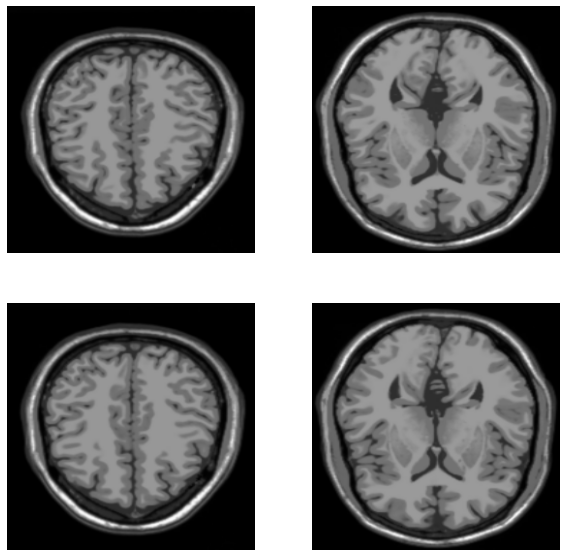

In [10]:
# Plotting T1 MRI Scans
plt.figure(figsize=(10, 10))
for images in tr1_train.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

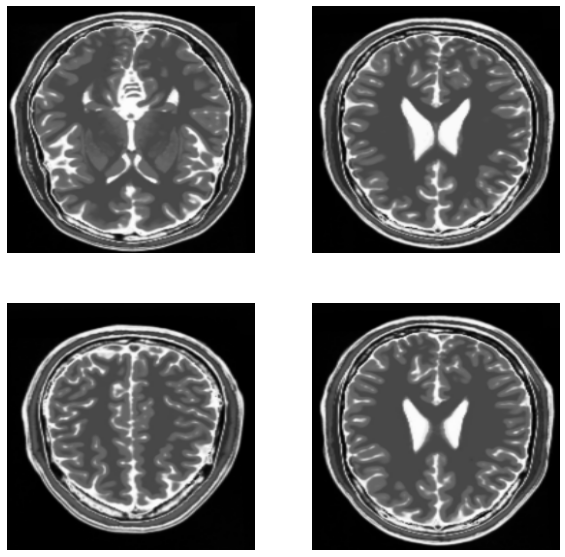

In [11]:
# Plotting T2 MRI Scans
plt.figure(figsize=(10, 10))
for images in tr2_train.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

## **3.1 Create a function to process your images with normalisation**


In [12]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image/127.5)-1
    return image

# Alternate
# normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

## **3.2. Apply the function to both the datasets**

In [14]:
# process both classes of MRI images
tr1_train = tr1_train.map(lambda x: (preprocess_image_train(x)))
tr2_train = tr2_train.map(lambda x: (preprocess_image_train(x)))
tr1_test = tr1_test.map(lambda x,_: (preprocess_image_train(x)))
tr2_test = tr2_test.map(lambda x,_: (preprocess_image_train(x)))

Checking if images are noremalized between [-1 to 1]

In [15]:
image_batch_tr1 = next(iter(tr1_train))
image_batch_tr2 = next(iter(tr2_train))
tr1_1 = image_batch_tr1[0]
tr2_1 = image_batch_tr2[0]
# Notice the pixels values are now in `[-1,1]`.
print(np.min(tr1_1), np.max(tr1_1))
print(np.min(tr2_1), np.max(tr2_1))

-1.0 0.96286297
-1.0 0.99518657


## **3.3 Visualise the MRI images after processing**

In [16]:
sample_tr1 = next(iter(tr1_train))
sample_tr2 = next(iter(tr2_train))

In [17]:
sample_tr1.shape

TensorShape([16, 256, 256, 3])

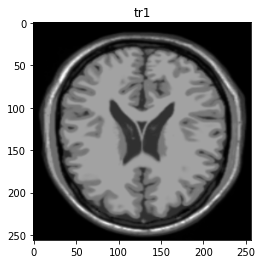

In [18]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

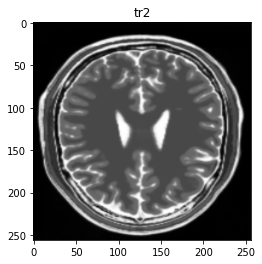

In [19]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

# **4. Model Building**

The architecture of generator is a modified U-Net.
- Instance Normalization

- Build Generator & Discriminator Architecture

- Define the loss functions

## **4.1 Instance Normalization**

In [20]:
class InstanceNormalization(tf.keras.layers.Layer):
    '''
    Instance vs Batch nom.: https://stackoverflow.com/questions/45463778/instance-normalisation-vs-batch-normalisation
    Normalization: https://www.tensorflow.org/addons/tutorials/layers_normalizations
    '''
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        # https://www.tensorflow.org/api_docs/python/tf/nn/moments
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

## **4.2. Building Generator & Discriminator architecture**

In [21]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [22]:
def unet_generator():
    down_stack = [
        downsample(64, 4, False), 
        downsample(128, 4), 
        downsample(128, 4), 
        downsample(128, 4), 
        downsample(128, 4) 
    ]
    up_stack = [
        upsample(128, 4, True), 
        upsample(128, 4, True),
        upsample(128, 4), 
        upsample(64, 4) 
    ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
generator_g = unet_generator() # Generates T2 images using T1 MRI Scans
generator_f = unet_generator() # Generates T1 images using T2 MRI Scans

In [24]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 128)  262400      sequential_1[0][0]               
______________________________________________________________________________________________

In [25]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [26]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [27]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_18 (Sequential)   (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_19 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_20 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 31, 31, 512)       2097152   
_________________________________________________________________
instance_normalization_18 (I (None, 31, 31, 512)       1024

In [28]:
sample_tr1.shape

TensorShape([16, 256, 256, 3])

In [29]:
sample_tr2.shape

TensorShape([16, 256, 256, 3])

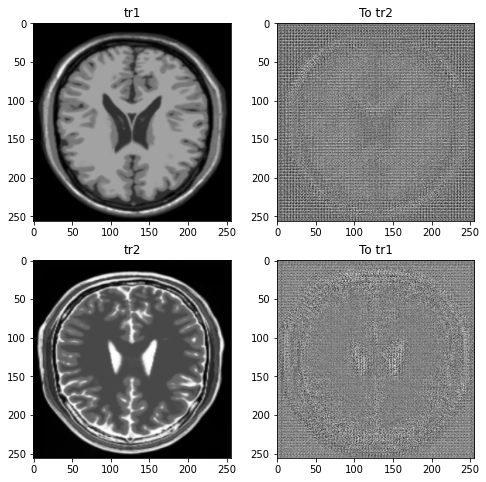

In [30]:
# Performing Predicton on untrained model
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

## **4.3. Defining Loss Function**

In [31]:
LAMBDA = 10.0

In [32]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [33]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

In [34]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [35]:
def calc_cycle_loss(real_image, cycled_image):
    '''
    Cycle consistency means that the recycled image should be closed to the original input 
    https://www.tensorflow.org/tutorials/generative/cyclegan
    '''
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [36]:
def identity_loss(real_image, same_image):
    '''
    Identity loss says that, if you fed image  to generator , it should yield the real image  or something close to image .
    '''
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [37]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# **5 Model Training**

- Initializing Checkpoint manager
- Model training
- Performing predictions on test set

## **5.1. Initializing Checkpoint manager**

In [38]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

# Ref: https://www.tensorflow.org/api_docs/python/tf/train/CheckpointManager
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f'Last Check Point: {ckpt_manager.latest_checkpoint}')
    print('Latest checkpoint restored!!')

In [39]:
def generate_images(model1, test1, model2, test2):
    prediction1 = model1(test1)
    prediction2 = model2(test2)
    plt.figure(figsize=(10, 10))
    display_list = [test1[0], prediction1[0], test2[0], prediction2[0]]
    title = ['Input TR1 Image', 'Predicted TR2 Image', 'Input TR2 Image', 'Predicted TR1 Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## **5.2. Training model for `250 EPOCHS`**

In [40]:
# Ref: https://www.tensorflow.org/guide/function
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

Extract Inage from TF.Dataset: https://stackoverflow.com/questions/67521759/how-to-extract-data-without-label-from-tensorflow-dataset

In [41]:
for image_x, image_y in tf.data.Dataset.zip((tr1_train, tr2_train)):
  print(image_x.shape,image_y.shape)

(8, 256, 256, 3) (16, 256, 256, 3)
(16, 256, 256, 3) (16, 256, 256, 3)
(16, 256, 256, 3) (11, 256, 256, 3)


In [42]:
for epoch in range(1,EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1_train, tr2_train)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, generator_f, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

Output hidden; open in https://colab.research.google.com to view.

## **5.3. Performing prediction on test data**

In [43]:
for image_x, image_y in tf.data.Dataset.zip((tr1_test, tr2_test)):
  print(image_x.shape,image_y.shape)

(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)
(1, 256, 256, 3) (1, 256, 256, 3)


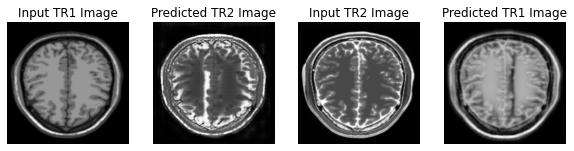

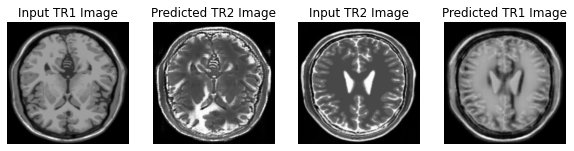

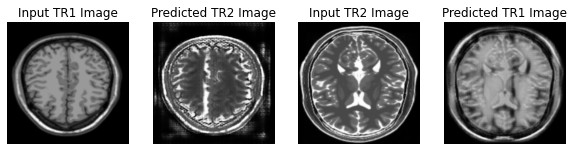

In [44]:
for image_x, image_y in tf.data.Dataset.zip((tr1_test, tr2_test)):
  generate_images(generator_g, image_x, generator_f, image_y)

# **6. Generating GIF**

In [45]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [46]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-kh2x_7kc
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-kh2x_7kc
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.047a807024a49d648ff635434d49e3f03a8cfc57a_-cp37-none-any.whl size=154244 sha256=bb2242c24112a665730464b34a86e158060f67cf9acac0a738f1735909bd4e24
  Stored in directory: /tmp/pip-ephem-wheel-cache-fukthhox/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [47]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.